# **Brain Tumor MRI Dataset:**

In [ ]:
!mkdir -p ~/.kaggle

!cp /content/kaggle.json ~/.kaggle/

In [ ]:
#!/bin/bash
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 90% 134M/149M [00:00<00:00, 1.39GB/s]
100% 149M/149M [00:00<00:00, 1.26GB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zip_ref.extractall('/content')

zip_ref.close()

In [ ]:
import os

glioma = "/content/Training/glioma"
meningioma = "//content/Training/meningioma"
notumor = "/content/Training/notumor"
pituitary = "/content/Training/pituitary"




print(len(os.listdir(glioma)))
print(len(os.listdir(meningioma)))
print(len(os.listdir(notumor)))
print(len(os.listdir(pituitary)))

1321
1339
1595
1457


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # convert to gray
    # transforms.Grayscale(num_output_channels=3)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='/content/Training', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/Testing', transform=transform)

In [ ]:
class_names = train_dataset.classes
print(class_names)
print(train_dataset.class_to_idx)

['glioma', 'meningioma', 'notumor', 'pituitary']
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, pin_memory=True)

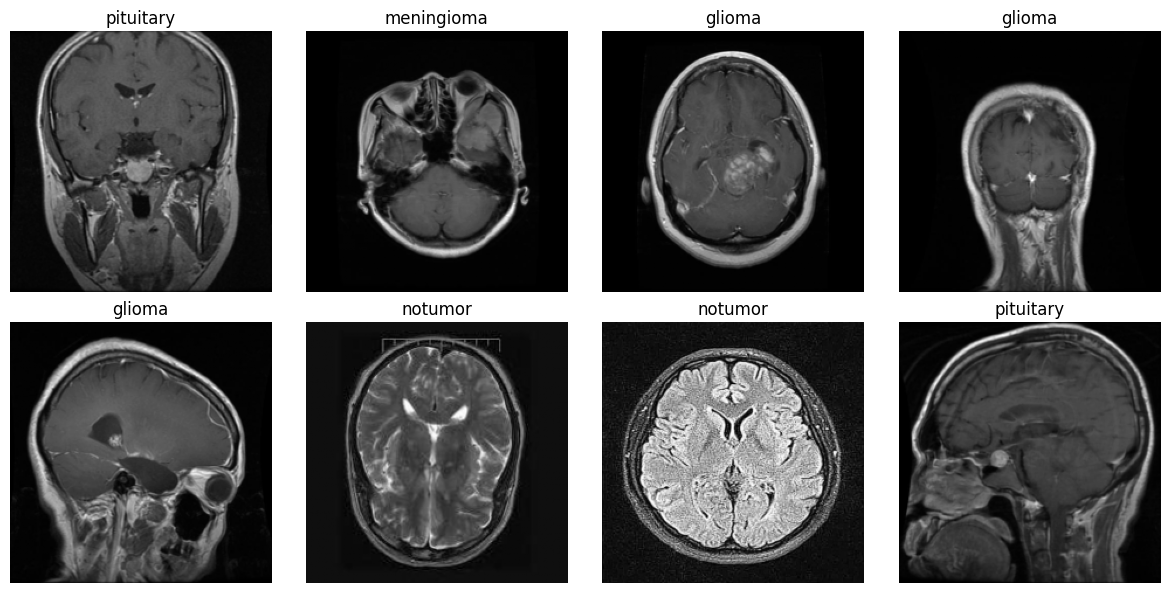

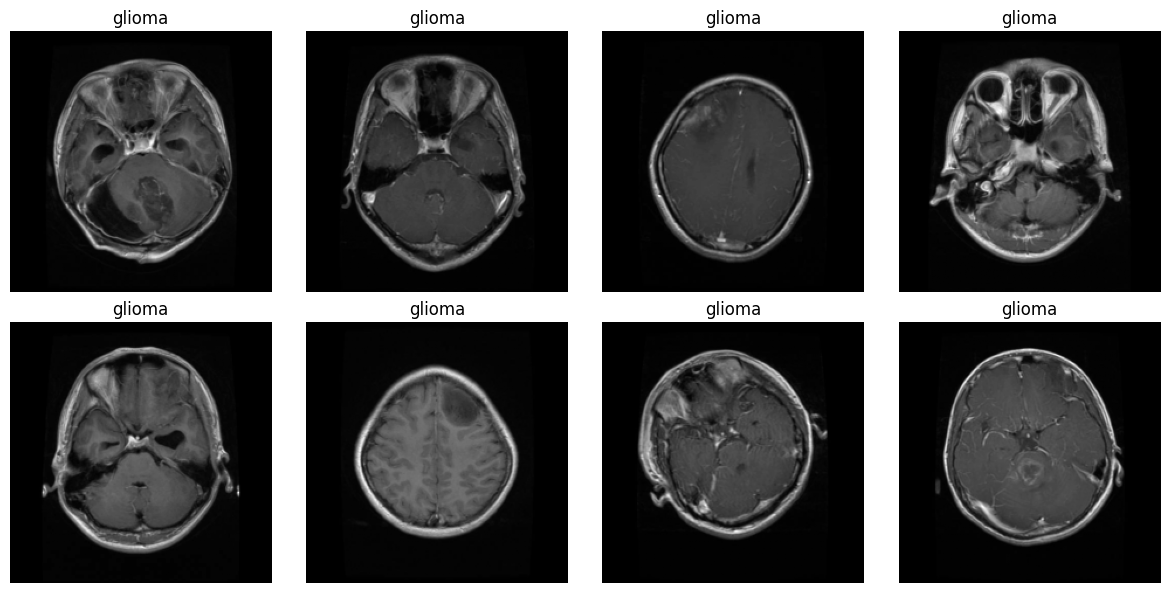

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def visualize_batch(images, labels):

  fig, axes = plt.subplots(2, 4, figsize=(12, 6))

  for img, label, ax in zip(images, labels, axes.flatten()):
      ax.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
      ax.set_title(class_names[label])
      ax.axis("off")

  plt.tight_layout()
  plt.show()

images, labels = next(iter(train_loader))
visualize_batch(images, labels)
images, labels = next(iter(test_loader))
visualize_batch(images, labels)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.features = nn.Sequential(
          nn.Conv2d(input_features, 128 , kernel_size=3, padding='valid'),
          nn.ReLU(),
          nn.Dropout(p=0.3),
          nn.BatchNorm2d(128),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(128, 64, kernel_size=3, padding='same'),
          nn.ReLU(),
          nn.Dropout(p=0.3),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 55 * 55, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(512, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(1).to(device)

epochs = 25
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(epochs):
    model.train()
    total_epoch_loss = 0
    correct = 0
    total = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    avg_loss = total_epoch_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.6f}  Accuracy: {accuracy:.2f}%")

Epoch [1/25]  Loss: 2.388144  Accuracy: 69.35%
Epoch [2/25]  Loss: 0.533277  Accuracy: 82.62%
Epoch [3/25]  Loss: 0.429611  Accuracy: 87.64%
Epoch [4/25]  Loss: 0.359478  Accuracy: 89.36%
Epoch [5/25]  Loss: 0.315148  Accuracy: 90.62%
Epoch [6/25]  Loss: 0.320678  Accuracy: 91.93%
Epoch [7/25]  Loss: 0.157193  Accuracy: 95.24%
Epoch [8/25]  Loss: 0.131918  Accuracy: 96.01%
Epoch [9/25]  Loss: 0.114506  Accuracy: 96.95%
Epoch [10/25]  Loss: 0.140152  Accuracy: 96.43%
Epoch [11/25]  Loss: 0.208373  Accuracy: 94.82%
Epoch [12/25]  Loss: 0.171908  Accuracy: 96.64%
Epoch [13/25]  Loss: 0.191095  Accuracy: 96.50%
Epoch [14/25]  Loss: 0.094014  Accuracy: 97.85%
Epoch [15/25]  Loss: 0.098751  Accuracy: 97.53%
Epoch [16/25]  Loss: 0.091758  Accuracy: 97.97%
Epoch [17/25]  Loss: 0.085352  Accuracy: 98.06%
Epoch [18/25]  Loss: 0.063622  Accuracy: 98.20%
Epoch [19/25]  Loss: 0.064735  Accuracy: 98.51%
Epoch [20/25]  Loss: 0.088369  Accuracy: 97.99%
Epoch [21/25]  Loss: 0.105645  Accuracy: 97.64%
E

In [ ]:
torch.save(model.state_dict(), "my_model.pth")

In [ ]:
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8115942028985508
